# Visualizações práticas do algoritmo SPIKE-Distance, para avaliar dissimilaridades entre Spike Trains

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Gerador de Spikes customizado para vários casos de estudo.

In [2]:

###########################################################################################
## Spike Count Generator for Desired spikes
def spike_count_generator(n=2, T=10, reduction_ratio=1, make_zero_st=False, make_full_st=False, make_complemetary_st=False):
    spike_counts_per_st = np.zeros(n)
    
    if(make_complemetary_st == True):
        rand_count = np.random.randint(2, int(T/reduction_ratio))
        spike_counts_per_st[0] = rand_count
        spike_counts_per_st[1] = T - rand_count
        
        return spike_counts_per_st
    
    for i in range(n):
        if (make_zero_st == True):
            spike_counts_per_st[i] = 0
            make_zero_st = False
            continue
        if (make_full_st == True):
            spike_counts_per_st[i] = int(T/reduction_ratio)
            make_full_st = False
            continue
        spike_counts_per_st[i] = np.random.randint(2, int(T/reduction_ratio))

    return spike_counts_per_st

###########################################################################################
## Spike Times Generator for Desired spikes
def spike_times_generator(spike_count=None, n=2, T=10, duplicate=False, complementary_spikes=False, time_shift=False, shift_step=0):
    desired_spike_train = []
    desired_spike_bin = np.zeros((n, T))
    spike_range = (0, T)
    if (duplicate == True):
        count = 0
        i = 0
        spike_time = random.sample(range(spike_range[0], spike_range[1]), int(spike_count[i]))
        while (count < n):
            desired_spike_bin[count][spike_time] = 1
            desired_spike_train.append(np.sort(spike_time))
            count += 1
    else:
        if (complementary_spikes == True):
            rand_times = random.sample(range(spike_range[0], spike_range[1]), int(spike_count[0]))
            all_times = range(spike_range[0], spike_range[1])
            compl_times = np.array(list(set(all_times).symmetric_difference(set(rand_times))))
            
            desired_spike_bin[0][rand_times] = 1
            desired_spike_bin[1][compl_times] = 1
            desired_spike_train.append(np.sort(rand_times))
            desired_spike_train.append(np.sort(compl_times))
            
        elif (time_shift == True):
            spike_time = random.sample(range(spike_range[0], spike_range[1]), int(spike_count[0]))
            shifted_time = np.add(spike_time, shift_step)
            out_of_bounds = np.argwhere(shifted_time >= T)
            if (out_of_bounds.shape[0] > 0):
                shifted_time[out_of_bounds] = T-1
                
            desired_spike_bin[0][spike_time] = 1
            desired_spike_bin[1][shifted_time] = 1
            desired_spike_train.append(np.sort(spike_time))
            desired_spike_train.append(np.sort(shifted_time))
        else:
            for i in range(n):
                spike_time = random.sample(range(spike_range[0], spike_range[1]), int(spike_count[i]))
                desired_spike_bin[i][spike_time] = 1
                desired_spike_train.append(np.sort(spike_time))
    
    
    return desired_spike_bin, desired_spike_train 

# Cálculo da Dissimilaridade e suas funções auxiliares:

In [5]:
# Tempos do spike antecessor ao instante t
def tP(t, neuron_spike_times):
    res = neuron_spike_times[np.where(neuron_spike_times <= t)]
    if(res.shape[0] == 0):
        return 0
    else:
        return max(res)

# Tempos do spike sucessor ao instante t   
def tF(t, neuron_spike_times):
    res = neuron_spike_times[np.where(neuron_spike_times > t)]
    if(res.shape[0] == 0):
        return 0
    else:
        return min(res)
    
# Intervalo entre spikes instantaneo
def x_isi(t, neuron_spike_times):
    return tF(t, neuron_spike_times)-tP(t, neuron_spike_times)

def media_x_isi(t, spike_times):
       
    return 0.5*(x_isi(t, spike_times[0])+x_isi(t, spike_times[1]))

# Diferencas absolutas entre sucessores e antecessores
def delta_tP(t, spike_times):
    return abs(tP(t, spike_times[0])-tP(t, spike_times[1]))

def delta_tF(t, spike_times):
    return abs(tF(t, spike_times[0])-tF(t, spike_times[1]))

# Intervalos para os spikes antecessores e sucessores
def xP(t, neuron_spike_times):
    return t - tP(t, neuron_spike_times)

def xF(t, neuron_spike_times):
    return tF(t, neuron_spike_times) - t

def media_xp(t, spike_times):
    return 0.5*(xP(t, spike_times[0]) + xP(t, spike_times[1]))

def media_xf(t, spike_times):
    return 0.5*(xF(t, spike_times[0]) + xF(t, spike_times[1]))

# Perfil de dissimiliaridade entre os spike trains - original
def So(t, spike_times):
    numerador = (delta_tP(t, spike_times)*media_xf(t, spike_times))+(delta_tF(t, spike_times)*media_xp(t, spike_times))
    denominador = media_x_isi(t, spike_times)**2
    return numerador/denominador

# Calcula a Dissimilaridade Normalizada [0, 1] dos perfis encontrados
def Dissimilarity(spike_times):
    count_negatives = 0
    S_original = np.zeros(T)
    for t in range(T):
        S_original[t] = So(t, spike_times)
        if (S_original[t] < 0):
            count_negatives += 1
    S_original_norm = (S_original-min(S_original))/(max(S_original)-min(S_original))
    
    return S_original_norm, count_negatives

# Dissimilaridade Total Media: Como estamos em tempo discreto, é apenas um somatório. Em tempo contínuo seria a integral dos perfis de dissimilaridade
def D_total (d_profile):
    return np.mean(d_profile)

def print_spikes(spikes, diss, T):
    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

    ax1.set_ylabel("ST1 Spikes")
    ax1.step(range(T), spikes[0], linewidth=2.0)

    ax2.set_ylabel("ST2 Spikes")
    ax2.step(range(T), spikes[1], linewidth=2.0)

    ax3.set_ylabel("Dissimilaridade entre ST1 e ST2")
    ax3.plot(range(T), diss, linewidth=2.0)

    plt.show()

# Execução de casos para compreensão prática do cálculo da dissimilaridade:

## Caso 1: Dois spikes aleatorios

[array([ 1,  2,  3,  4,  5,  6,  7,  9, 12, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 41, 43,
       44, 45, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84,
       85, 89, 91, 93, 95, 96, 97, 98, 99]), array([ 9, 10, 27, 30, 31, 49, 65, 82])]


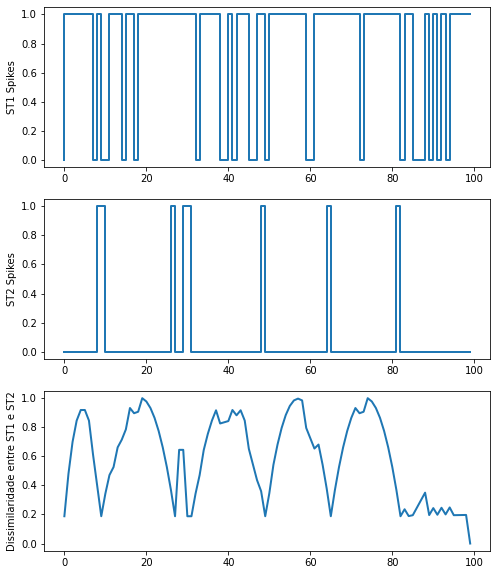

Dissimilaridade Total entre ST1 e ST2: 0.2974178310952029


In [7]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 2: Spikes Identicos. Avaliando qual deve ser a dissimilaridade quando temos spikes iguais.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T, duplicate=True)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 3.0: Spikes Complementares Aleatórios. Nesse caso eles são 100% diferentes em tempos de disparo. O perfil de dissimilaridade assume valores negativos.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T, complementary_spikes=True)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 3.1: Spikes Complementares, sendo um completo de 1s e outro de 0s.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T, make_full_st=True, make_zero_st=True)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 4.1: (Teste com spikes extremos): Um Spike de 1s e outro aleatório. Aqui o perfil contém valores negativos.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T, make_full_st=True)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 4.2 (Teste com spikes extremos): Um Spike de 0s e outro aleatório.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T, make_zero_st=True)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 5.1: Dois spikes com desvio de 1 unidade de tempo, para todos os instantes. Aqui, ST1 atrasado em 1 unidade de ST2.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T, time_shift=True, shift_step=1)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

## Caso 5.2: Dois spikes com desvio de 1 unidade de tempo, para todos os instantes. Aqui, ST1 adiantado em 1 unidade de ST2.

In [ ]:
# Definição dos parâmetros iniciais:

n = 2  # Quantidade de spike trains a comparar
T = 100 # Tempo total de simulação

# Geração de 2 Spike Trains
st_count = spike_count_generator(n, T)
ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T, time_shift=True, shift_step=-1)

print(STs)

S_original_norm, _ = Dissimilarity(STs) 
print_spikes(ST_bin, S_original_norm, T)
print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 

# Análise dos valores negativos de dissimilaridade em função do tempo de simulação:

In [19]:
times = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 800, 1000]
negatives_diss = []
# Escolha de um caso encontrando negativos: Complementares Aleatórios
n = 2  # Quantidade de spike trains a comparar

for T in times:
    # Geração de 2 Spike Trains
    st_count = spike_count_generator(n, T, make_full_st=True)
    ST_bin, STs = spike_times_generator(spike_count=st_count, n=n, T=T)

    S_original_norm, negatives = Dissimilarity(STs) 
    negatives_diss.append(negatives)
    #print_spikes(ST_bin, S_original_norm, T)
    #print("Dissimilaridade Total entre ST1 e ST2: {}".format(sum(S_original_norm)/(2*T))) 
    

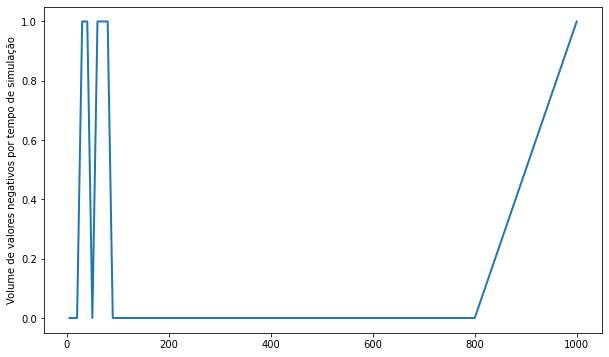

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_ylabel("Volume de valores negativos por tempo de simulação")
ax.plot(times, negatives_diss, linewidth=2.0)

plt.show()